# Lab 2: *Kernelized* machine learning

Advanced Topics in Machine Learning -- Spring 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_UniTS_2023_Lab_02_Kernel_ridge_regression_and_kPCA.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

### *Kernel Regression* and *Kernel Ridge Regression*

Recall that the solution of **linear regression** can also be written as: $w=(X^{T}X)^{-1}X^{T}y=X^{T}(XX^{T})^{-1}y$

Let $X\in R^{N\times d}$: we have $X^{T}X\in R^{d\times d}$ and $K=XX^{T}\in R^{N\times N}$. Whether it is more convenient to (pre)compute which matrix product (among $X^{T}X$, $XX^{T}$) depends on the $d/N$ ratio.

As far as predictions are concerned, we have that: $f(z)=z^{T}w=z^{T} X^{T}(XX^{T})^{-1}y= \alpha^{T}(z)K^{-1}y$, with $\alpha(z)=z^{T}X^{T}=K(z,X)\in R^{1\times N}$.

How can we move to the non-linear regression case?  We just substitute $x\rightarrow \phi(x)$, and the reasoning above can be repeated!

For more information, you can look up [this Medium article](https://knork.medium.com/linear-regression-in-python-from-scratch-with-kernels-e9c37f7975b9) or [this code-first tutorial](https://github.com/luigicarratino/Tutorial_Kernels_MLSS2019_London/blob/master/Tutorial%20Kernel.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.spatial.distance import pdist, squareform

**Exercise 1: linear data regression**
1. Generate and plot a dataset consisting in $100$ datapoints in the form $(x_i,y_i)$. The $x_i$ are sampled uniformly in $[2,30]$, whereas the $y_i$ are sampled from a Gaussian distribution centred in $2x_i + 50$ having unit variance.

In [2]:
np.random.seed(42)
x = np.random.uniform(2,30,100)
y = 2 * x + 50 + np.random.normal(0, 1, x.shape[0])

2. Fit a linear regression model to the data, **with no learnable intercept** (i.e. fix it to zero), and plot the predictions of the resulting model compared to the data.

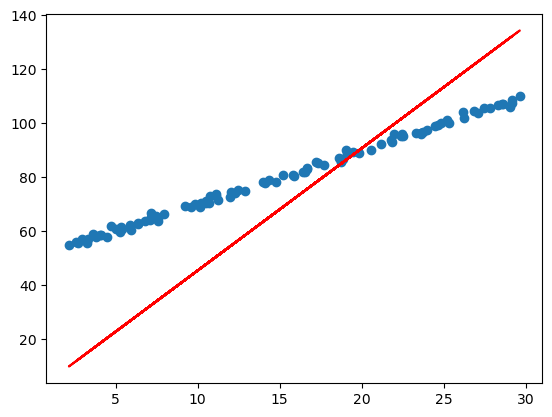

In [3]:

new_axis = x[:, np.newaxis]
w = np.linalg.inv(new_axis.T.dot(new_axis)).dot(new_axis.T.dot(y))
plt.plot(x, y, 'o')
plt.plot(x, w*x, 'r')

3. Fit a linear regression model to the data, **with learnable intercept**, and plot the predictions of the resulting model compared to the data.

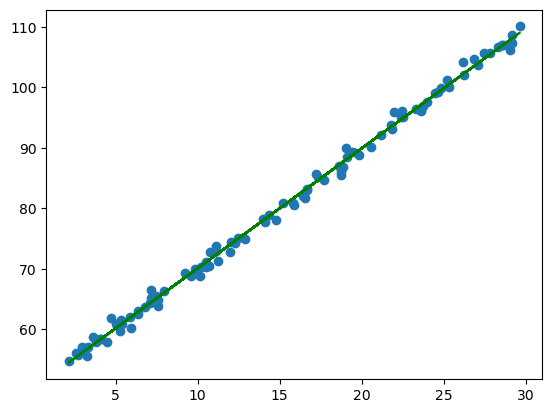

In [4]:
x_intercept = np.stack([new_axis[:,0], np.ones(new_axis.shape[0])], axis=1)
w_newax = np.linalg.inv(x_intercept.T.dot(x_intercept)).dot(x_intercept.T.dot(y))  
plt.plot(x, y, 'o')
plt.plot(x, np.sum(w_newax*x_intercept,axis=1), 'g')

4. Fit a linear ridge regression model to the data, and plot the predictions of the resulting model compared to the data.

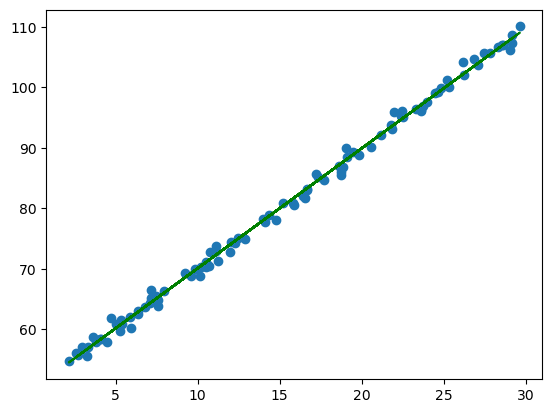

In [5]:
lambda_c = 0.0001
w_reg = np.linalg.inv(x_intercept.T.dot(x_intercept) + lambda_c*np.eye(2)).dot(x_intercept.T.dot(y))
plt.plot(x, y, 'o')
plt.plot(x, np.sum(w_reg*x_intercept,axis=1), 'g')

**Exercise 2: Kernel regression on *periodic* data**
1. The following dataset is given. Plot it.

In [6]:
xkr = np.linspace(2, 30, 100)
ykr = xkr + 4 * np.sin(xkr) + 4 * np.random.rand(xkr.shape[0])

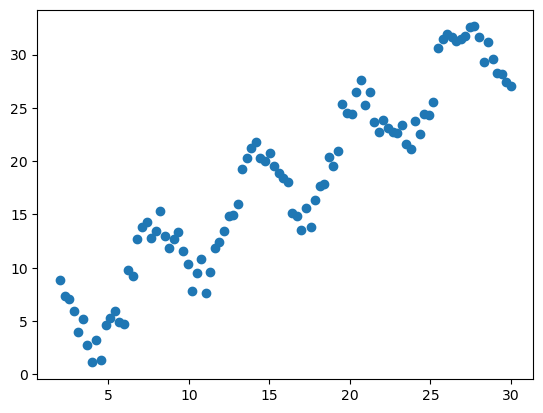

In [7]:
plt.plot(xkr, ykr, 'o')

2. Define a function that computes the Gaussian kernel value between two vectors, represented as numpy arrays.

In [2]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(-np.dot( x1-x2, x1-x2)/(2*sigma**2))

3. With the fuction just defined, compute the Gram matrix of the dataset. Use a Gaussian kernel with $\sigma=1$.

In [29]:
gram = np.stack([gaussian_kernel(np.repeat(i,100),xkr,1) for i in xkr], axis=1)

4. Fit a kernel ridge regression model to the data, and plot the resulting model compared to the data.

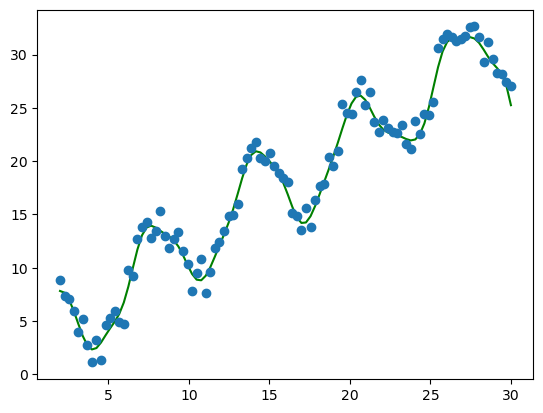

In [31]:
lambda_c = 0.001
alpha = np.linalg.inv(gram+lambda_c*100*np.eye(100)).dot(ykr)
sol = np.asarray([np.sum(alpha*gram[i,:]) for i in range(100)])
plt.plot(xkr,sol,'g')
plt.plot(xkr, ykr, 'o')

### *Kernel PCA* and the *Radial Basis Function* (RBF) Kernel

Let us briefly recap the key concepts of PCA. We have a dataset $X\in R^{N\times d}$, and we want to find a new basis $Z\in R^{N\times d}$ such that the variance of the projected data is maximized. This is equivalent to finding the eigenvectors of the covariance matrix $C=X^{T}X$.

This requires the data to be centered, i.e. $X_{i}^{(j)}-\mu_{j} \rightarrow X_{i}^{(j)}$, where $\mu_{j}=\frac{1}{N}\sum_{i=1}^{N}X_{i}^{(j)}$ is the mean of the $j$-th feature.

We can also write the eigenvalue problem in components, as follows: $Cz_{j}=\lambda_{j}z_{j}$, where $z_{j}$ is the $j$-th eigenvector and $\lambda_{j}$ is the corresponding eigenvalue. The eigenvectors are orthogonal, i.e. $z_{j}^{T}z_{k}=0$ for $j\neq k$.

Moving to the kernelized case, we operate the substitution $x\rightarrow \phi(x)$, and the eigenvalue problem becomes $C_{K}v=\lambda v$ with $C_{K}=\frac{1}{N}\sum_{i}\phi(x_{i})\phi^{T}(x_{i})$, $\phi(\cdot)$ being a generic feature map.

One can prove that solutions of the eigenvalue problem are in the form $v=\sum_{i}\alpha_{i}\phi(x_{i})$. Multiplying both sides of $C_{K}v=\lambda v$ by $\phi(x_{k})$ and substituting, we obtain $N\lambda \alpha=K \alpha$.

Such reasoning still requires normalization, i.e. $ \phi(x)-\frac{1}{d}\sum_{i}(\phi(x))_{i} \rightarrow \phi(x)$. The resulting kernel $K$ is in the form $K := K-2Id_{1/n}K + Id_{1/n}K Id_{1/n}$ with $Id_{1/n}$ the matrix with entries $1/n$.

A more thorough explanation can be found in [this blogpost](https://sdat.ir/en/sdat-blog/python-kernel-tricks-and-nonlinear-dimensionality-reduction-via-rbf-kernel-pca).


**Exercise 3: Kernel PCA**
1. A *Half Moons* dataset of $100$ points is given below. Plot it.

In [3]:
xhm, yhm = make_moons(n_samples=500, random_state=123)

In [67]:
xhm.shape

(500, 2)

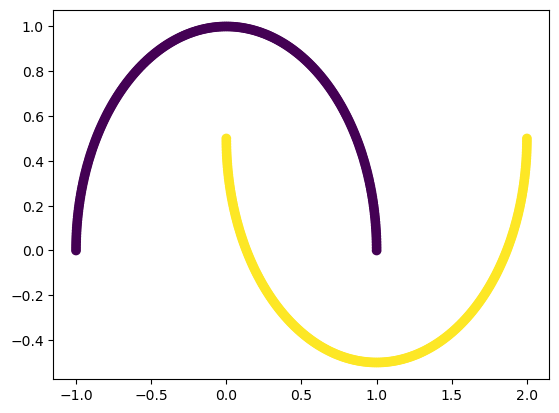

In [4]:
colors = {0: 'red', 1:'blue'}
plt.scatter(xhm[:,0],xhm[:,1], c=yhm)

2. Apply the PCA algorithm to the dataset, and plot the resulting projection using the first 2 principal components.
**Hint**: you can use the `PCA` class from `sklearn.decomposition`.

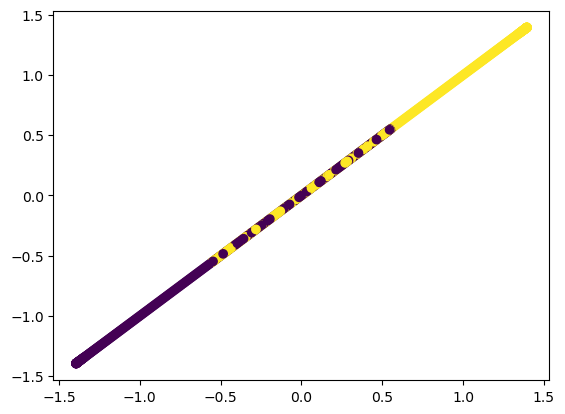

In [66]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(xhm)
X = pca.transform(xhm)
plt.scatter(X[:,0],X[:,1], c=yhm)


3. Repeat the previous step, but plotting just the first principal component. Comment on the separability of the two classes.

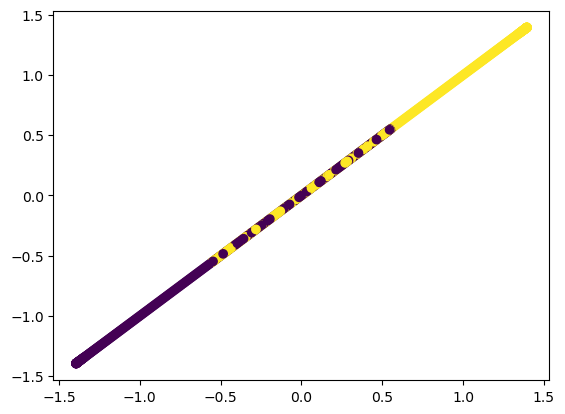

In [70]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=1)
pca.fit(xhm)
X = pca.transform(xhm)
plt.scatter(X,X, c=yhm)

4. Implement a function that computes the *Radial Basis* PCA algorithm of the dataset, given as a NumPy array.

In [7]:
from scipy.linalg import eigh

In [5]:
def kpca(x_data, gamma, n_components):
    """
    Implementation of a RBF kernel PCA.

    Arguments:
        x_data: A MxN dataset as NumPy array where the samples are stored as rows (M),
           and the attributes defined as columns (N).
        gamma: The free parameter (coefficient) for the RBF kernel.
        n_components: The number of components to be returned.

    """
    gram = np.vstack([np.asarray([gaussian_kernel(j,i,2/gamma) for i in x_data]) for j in x_data])
    N = gram.shape[0]
    one_n = np.ones((N,N)) / N
    gram = gram - one_n.dot(gram) - gram.dot(one_n) + one_n.dot(gram).dot(one_n)
    eigvals, eigvecs = eigh(gram)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    xpcs = np.column_stack([eigvecs[:, i] for i in range(n_components)])
    return xpcs

5. Apply the function just defined to the dataset, and plot the resulting projection using the first 2 principal components.

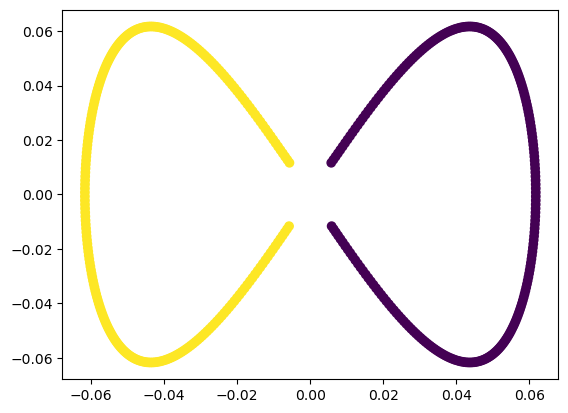

In [8]:
x_kpca = kpca(xhm, gamma=15, n_components=2)

plt.scatter(x_kpca[:,0],x_kpca[:,1], c = yhm)

6. Repeat the previous step, but plotting just the first principal component. Comment on the separability of the two classes.


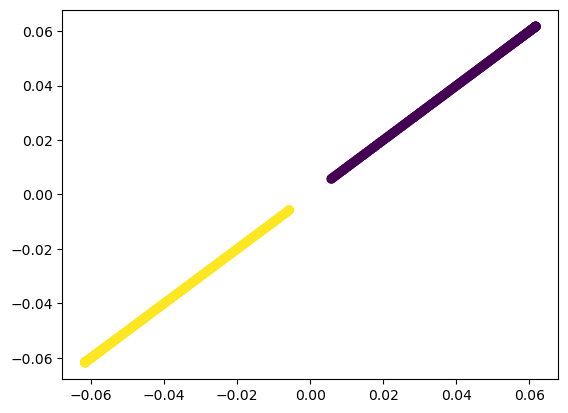

In [219]:
x_kpca = kpca(xhm, gamma=15, n_components=1)

plt.scatter(x_kpca[:,0],x_kpca[:,0], c = yhm)
